# How have neuroscience subfields changed over time?

**Motivation**: As a neuroscience PhD student, I always hear -- or observe -- that certain subfields of neuroscience are getting more popular, while others, less.  I wanted to see if there was any evidence for claim using data-driven methods. So, the overall question here is, **how have neuroscience subfields changed over time?**

What I have done so far is to scrape abstract and project data from the NIH from 1985-2016, filtered out projects to get neuroscience R01s that were funded, and converted all the abstract text into a processable form. 

Now, using the abstracts, I will implement a clustering method called latent dirichlet allocation (LDA) to get clusters of abtracts unified by their neuroscience subfield. 

Finally, I will look inside each cluster and simply track how each subfield has changed over time, based on proportion of projects in that subfield for any given year.

This was much more difficult than I expected. Most of my work isn't shown here, but I tried all sorts of different clustering methods (hierarchical clustering, K-means, affinity propagation) with different parameters (distance, TF-IDF, PCA) before settling into LDA. Simply put, LDA worked the best - by far - for topic extraction.

-----

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot

from gensim import corpora, models
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Get the data
Read in csv file containing wordlist and year for each neuroscience R01.

In [2]:
df = pd.read_csv('all_years.csv')

In [3]:
df.head()

,Unnamed: 0,wordlist,year
0,21427,"['program', 'research', 'design', 'investig', ...",1985
1,21430,"['mammalian', 'alkaloid', 'result', 'condens',...",1985
2,21435,"['exist', 'cognit', 'preceptualmotor', 'defici...",1985
3,21436,"['although', 'alcohol', 'alcohol', 'abus', 're...",1985
4,21439,"['recent', 'neuropsycholog', 'studi', 'detect'...",1985


In [4]:
df.shape

(124997, 3)

# How has the number of neuro projects changed over time?

I expected the number of neuroscience projects to increase with time.  I don't know what the nature of that increase looks like (linear? exponential?), but the number of projects should go up.  Neuroscience is not a dying field.

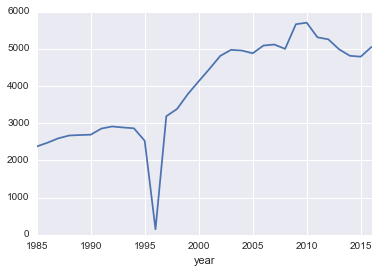

In [5]:
df.groupby('year')['wordlist'].count().plot()

- There is a trend of an increase funding for neuroscience R01s and then stagnation from about 2005.
- Why the sudden drop in abstracts in 1996? Digging into the dataframe for 1996, I found that many of the abstracts were not recorded and thus were given NaN values -- for all R01s in 1996, only 1024 of them had abstract text. For this project, it is fine to simply drop all the data for 1996 since I haver 30 years of data.

In [6]:
# drop 1996 from df
df = df[df.year != 1996]

In [7]:
df.shape

(124849, 3)

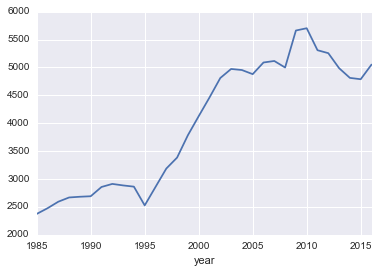

In [8]:
df.groupby('year')['wordlist'].count().plot()

This looks much better. 1995 looks potentially concerning, and I'd have to go back to the 1995 abstracts to see whether a huge chunk of them were missing or not, but I'm just not going to worry about it for now.

# Get document-term matrix

The first time I did this, I actually did this manually because I wanted to go through the process and understand how things were actually done instead of zipping through some pre-made functions. Yes, it is reinventing the wheel a little bit, but it helps me learn. 

Most of the work is easily done using the gensim package, which I highly recommend.

In [ ]:
def get_clean_wordlist(series):
    """
    input: a pandas Series containing the abstract wordlist (df.wordlist) where each row is a string representation of a list
    returns: the list representation of a wordlist, which is required for gensim.
    """
    
    texts = list(series)
    
    # clean wordlist
    clean_texts = []
    for text in texts:
        text = text[2:-2].split("', '")
        clean_texts.append(text)
    return clean_texts

In [ ]:
# implement get_clean_wordlist
texts = get_clean_wordlist(df.wordlist)

In [ ]:
# get unique words list
dictionary = corpora.Dictionary(texts)

In [ ]:
# get document-term matrix
corpus = [dictionary.doc2bow(tex) for tex in texts]

# Extract topics from neuroscience projects!

**I used LDA for extracting topics from neuroscience abstracts over the last 30 years.**

In [ ]:
def lda(corpus, num_topics, passes, alpha):
    """
    inputs -
    corpus: document-term matrix; nested list
    num_topics: integer, how many topics
    passes: integer
    alpha: float; how many topics do you expect each document to belong to
    
    This function computes LDA, visualizes it using pyLDAvis, and returns the model.
    """
    lda = models.ldamodel.LdaModel(corpus, num_topics=num_topics, passes=passes, alpha=alpha)
    followers_data =  pyLDAvis.gensim.prepare(lda, corpus, dictionary)
    pyLDAvis.display(followers_data)

    pyLDAvis.save_html(followers_data, 'LDA_' + str(num_topics) + '_' + str(passes) + '_' + str(alpha) + '.html')
    
    return lda

**LDA implementation.** I tried multiple number of topics, and played around with alpha and the number of passes, but noticed that alpha of 0.01 works best (while controlling for the other variables), and obviously number of passes is better when higher, it's just a matter of time. But, 20 topics seems to work the best.

In [ ]:
ldas_dict = {}
# num_topics = [8, 15, 20, 40]
num_topics = [20]
passes = 50
alpha = 0.01

for topic in num_topics:
    lda_model = lda(corpus, topic, passes, alpha)
    ldas_dict[topic] = lda_model

In [ ]:
ldas_dict

**Get topic labels based on your knowledge of neuroscience.**

In [15]:
topics_20 = ['human neuro - longitudinal', 
             'systems neuroscience - higher level cognition',
             'molecular neuroscience and genetics', 
             'molecular neuroscience - signaling and trafficking', 
             'systems neuroscience - circuitry',
             'synapse physiology',
             'neurodevelopment',
             'whole brain imaging',
             'neurotoxicity',
             'neuroinflammation',
             'addiction & depression',
             'itch and pain',
             'sleep, sex, and stress',
             'reward - dopamine, cocaine',
             'neurodegeneration',
             'cardiovascular',
             'alcohol and development',
             'metabolism - obesity, diabetes, hunger, satiety',
             'cancer',
             'sensory systems'
            ]
len(topics_20)

20

# Quantification and visualization
## How big is each topic overall?
I will try to quantify how big each topic is in two ways. First, split up project based on topic probability. And get topic size by summing up proportions of each project inside it.

In [ ]:
def get_topic_size_split_project(num_topics, corpus, lda):
    """
    inputs: 
    num_topics, integer
    corpus, document-term matrix
    lda, model
    returns: dictionary containing topic number as keys and number of projects (as a proportion) as values.
    """
    # initialize topic dict
    topic_dict = {}
    for j in range(num_topics):
        topic_dict[j] = 0
    
    # add project proportions into each topic
    for i in range(len(corpus)):
        doc_topics = lda.get_document_topics(corpus[i])
        for topic in doc_topics:
            topic_dict[topic[0]] += topic[1]
    
    return topic_dict

Second, bin the entire project into a topic space based on highest probability.

In [ ]:
def get_topic_size_whole_project(num_topics, corpus, lda):
    """
    inputs: 
    num_topics, integer
    corpus, document-term matrix
    lda, model
    returns: dictionary containing topic number as keys and number of projects (as a whole) as values.
    """
    from operator import itemgetter
    
    # initialize topic dict
    topic_dict = {}
    for j in range(num_topics):
        topic_dict[j] = 0
    
    # add whole projects into topic
    for i in range(len(corpus)):
        doc_topics = lda.get_document_topics(corpus[i])
        np_topics = np.array(doc_topics)
        index = np.argmax(np_topics, axis=0)[1]
        topic_dict[doc_topics[index][0]] += 1
        
    assert (sum(topic_dict.values()) == len(corpus)), "algo wrong"
    return topic_dict

In [ ]:
def topic_size_scatter(topic_dict):
    """
    input: dictionary containing topic number as keys and sum of projects as values
    returns: 2 scatterplot-ready lists
    """
    td_list = [(k,v) for k,v in topic_dict.items()] 
    x_td_list = [x[0] for x in td_list]
    y_td_list = [x[1] for x in td_list]
    return x_td_list, y_td_list

### Implementation: How similar are the two ways I choose to represent topic size?

In [ ]:
def topic_size(num_topics, corpus, lda):
    """
    inputs: 
    num_topics, integer
    corpus, document-term matrix
    lda, model
    plots: scatterplot of topic v. projects per topic. Red dots are whole projects; blue dots are sums of project proportions
    returns: dictionary containing topic number as keys and number of projects (as a whole) as values.
    """
    # get projects
    split_dict = get_topic_size_split_project(num_topics, corpus, lda)
    whole_dict = get_topic_size_whole_project(num_topics, corpus, lda)

    # get scatterplot-ready data
    s_x, s_y = topic_size_scatter(split_dict)
    w_x, w_y = topic_size_scatter(whole_dict)

    # make scatterplots
    pyplot.scatter(s_x, s_y, color='b')
    pyplot.scatter(w_x, w_y, color='r')
    pyplot.xlabel('Topic number')
    pyplot.ylabel('Project count')
    pyplot.title('Topic size')
    
    return whole_dict

In [ ]:
whole_dict = topic_size(20, corpus, ldas_dict[20])

- blue dots show count by splitting up each project based on probability
- red dots show project count by binning entire project into topic space based on highest probability

Pretty similar! There is obviously some variation but not major enough to warrant doing anything with it. Regardless, I will use whole projects per topic because the below analysis is not going to make sense otherwise.

## How has the size of each topic changed over time?

In [ ]:
# get labels for each topic
def get_topic_labels(num_topics, corpus, lda):
    topic_labels = []
    for i in range(len(corpus)):
        doc_topics = lda.get_document_topics(corpus[i])
        np_topics = np.array(doc_topics)
        index = np.argmax(np_topics, axis=0)[1]
        topic_labels.append(doc_topics[index][0])
    return topic_labels

# Implementation
df['topic'] = get_topic_labels(20, corpus, ldas_dict[20])

In [ ]:
# Topics are 1-indexed, so I want to add 1 to everything for consistency.
df['topic'] = df.topic + 1

In [ ]:
# Save file because (and this has happened multiple times now) LDA is very memory intensive and crashes occasionally.
df.to_csv('to_plot.csv')

-----
# So, how big is each topic over time?

Initially I saw two ways to represent topic size over time. But first, let's just start by plotting the absolute number of projects for each topic over time. Just to see what happens.

## Plot by absolute number of projects per topic

In [7]:
to_plot = pd.read_csv('to_plot.csv')

In [8]:
topics_time = pd.DataFrame(to_plot.groupby(['year', 'topic'])['wordlist'].count())

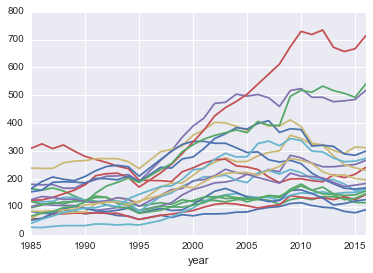

In [9]:
topics_time.unstack().plot()
pyplot.gca().legend_.remove()

As expected, it looks like all topics are increasing over time. Obviously this is just because neuroscience in general (and science in general) is being increasingly funded.

Now, let's plot neuroscience topics in proportions.

## Plot by proportion of projects

In [10]:
from bokeh.charts import Line, output_file, show
from bokeh.models import HoverTool, Legend
from bokeh.plotting import figure, ColumnDataSource
from bokeh.palettes import Spectral6
from itertools import cycle
from bokeh.io import push_notebook, show, output_notebook

output_notebook()

Loading BokehJS ...

In [11]:
topics_matrix = topics_time.unstack().as_matrix()

In [12]:
def get_bokeh(df_props, filename):
    """
    Get bokeh plot using dataframe
    """
    colors = Spectral6
    colorcycler = cycle(colors)

    source = ColumnDataSource(df_props)
    p = figure(plot_width=800, plot_height=400, x_axis_label='Year', y_axis_label='Proportion', 
              title='How has neuroscience changed over time?')

    for column in df_props.columns:
        line = p.line(x = df_props.index, y=column, source=source, legend=False,
                      line_color=next(colorcycler), line_width=3, line_cap='round', 
                      line_join='round')

        p.add_tools(HoverTool(tooltips=[("Topic", "&nbsp;%s" % column),], renderers=[line]))

    output_file(filename + '.html')
    show(p)
    
def get_indiv_plots(df_props, ylim):
    """
    get plots of each topic over time
    """
    # topic-specific plots
    col_list = list(df_props.columns)
    for i in col_list:
        pyplot.figure()
        df_props[i].plot()
        pyplot.title(i)
        pyplot.xlabel('Year')
        pyplot.ylabel('Proportion')
        pyplot.ylim([0,ylim])

### Plots proportions of projects by year

In [13]:
years = list(range(1985,1996)) + list(range(1997,2017))
years = [str(year) for year in years]
topic_col = range(1,21)

In [16]:
proportions = []
for i in topics_matrix:
    proportion = i/np.sum(i)
    proportions.append(proportion)

df_props = pd.DataFrame(proportions, index=years, columns=topic_col)
df_props.columns = topics_20

get_bokeh(df_props, 'proportions')

# [Get bokeh summary plot here](http://htmlpreview.github.io/?https://github.com/zcandiceyip/nih_grants/blob/master/proportions.html)

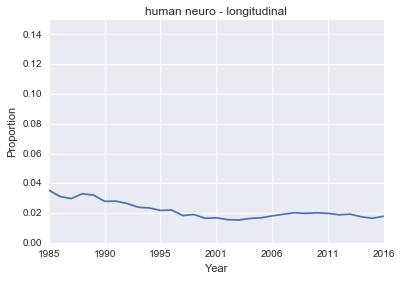

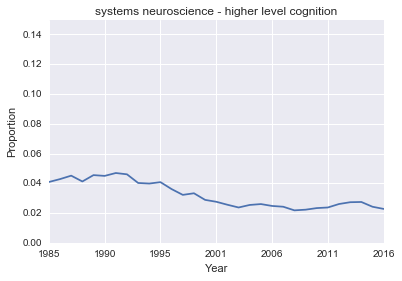

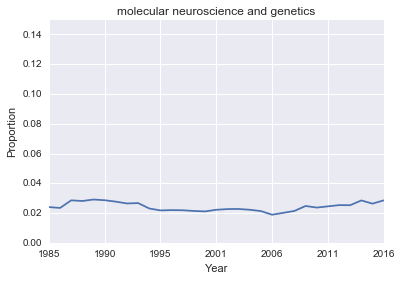

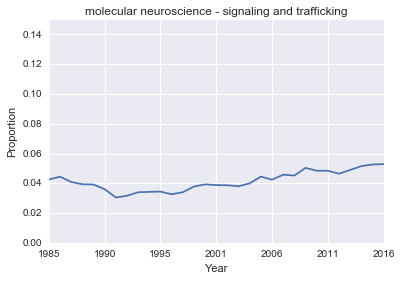

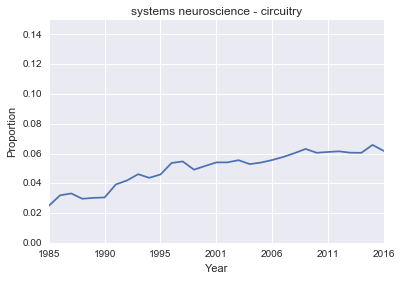

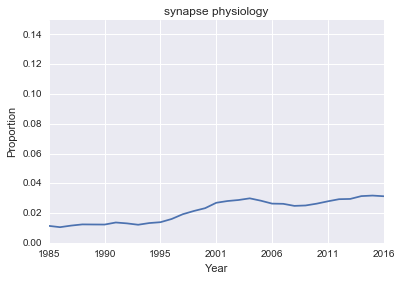

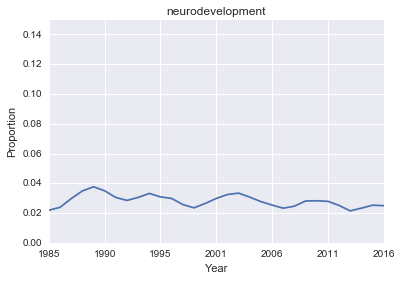

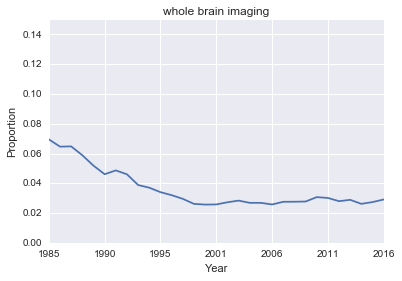

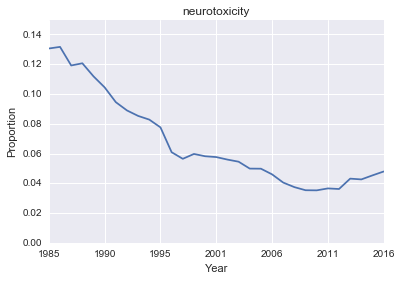

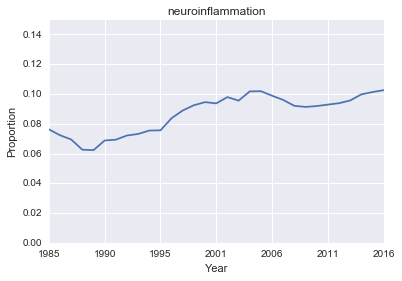

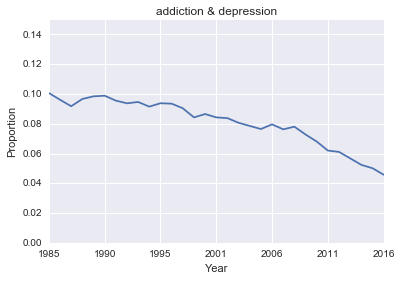

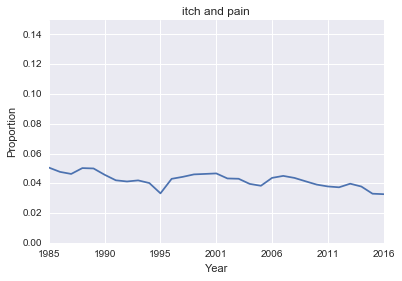

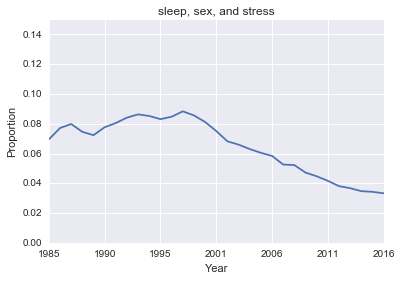

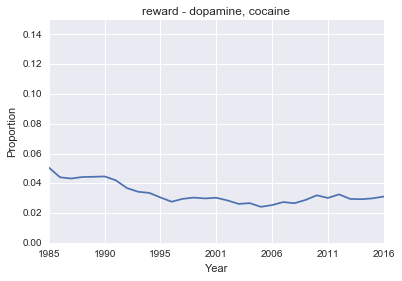

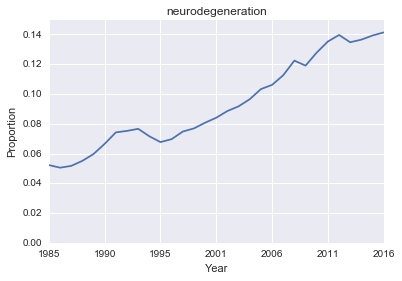

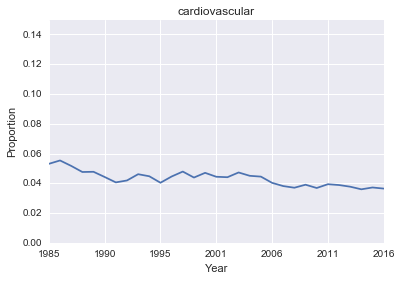

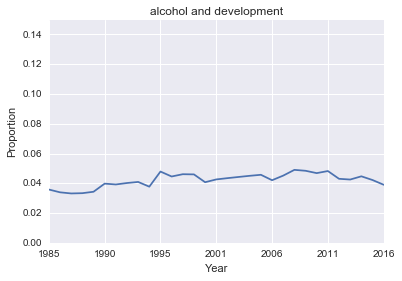

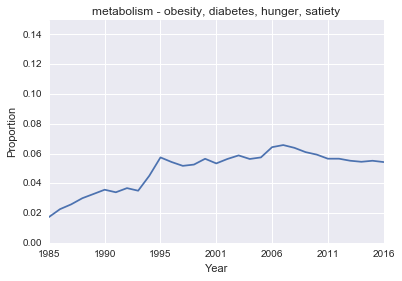

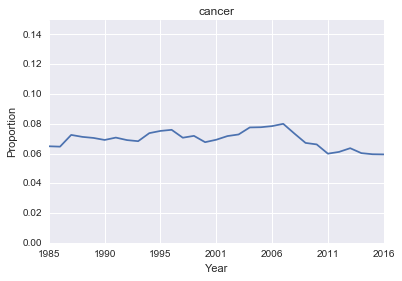

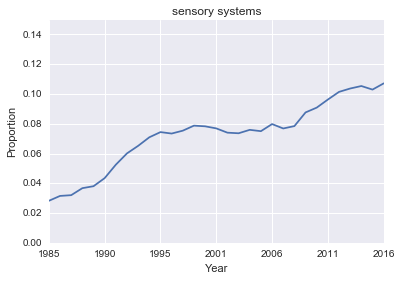

In [17]:
get_indiv_plots(df_props, 0.15)

# So.. how HAS neuroscience changed over time?

What have we learned about neuroscience as a field? 

## 1. Some fields got really popular:

All of these make sense — computational methods have gotten significantly better since the late 80s/early 90s. Genetic tools for physiology have gotten so much better (optogenetics, for example) with time which explains why synapse physiology is on this list. Neurodegeneration is an extremely lucrative industry (think Parkinson’s and Alzheimer’s). Neuroinflammation is also not surprising.
- neuroinflammation
- systems neuroscience - circuitry
- synapse physiology
- neurodegeneration
- metabolism
- sensory systems

## 2. Most subfields stayed neutral in terms of growth/didn’t change much.
- human neuro - longitudinal
- systems neuroscience - higher level cognition
- molecular neuroscience and genetics
- molecular neuroscience - signaling and trafficking
- neurodevelopment
- itch and pain
- reward
- cardiovascular
- alcohol and development
- cancer

## 3. Some fields got less popular with time. The major ones: 
- whole brain imaging
- neurotoxicity
- addiction and depression
- sleep, sex, and stress

I don't really know much about addiction/depression, sleep/sex/stress, neurotoxicity (perhaps because it has been trending downwards since I became a research scientist).  I’m a bit surprised about the whole brain imaging one. I thought those imaging methods got much better with time. Maybe if I were in that field, I would know more about why.

I listed all twenty topics in the above three lists lest I get accused of cherrypicking.

## 4. And finally, neurodevelopment. 
Yes. What I have lived and breathed for the last 5.5 years (for my PhD). 

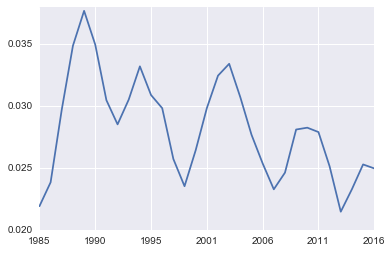

In [18]:
df_props.neurodevelopment.plot()

This makes me a bit sad, although frankly quite in line with what I expected. Actually, almost exactly what I would have expected. Obviously it is not that bad -- the y-axis shows us that we are dealing in very small amounts. Could be worse.

## 5. Maybe I should be more optimistic -- maybe my model is wrong! 
Actually it is probably true that my model is wrong -- "all models are wrong, but some are useful".

There are of course many, many confounding factors for my conclusions.  It could be that NIH R01 abstracts aren't the right estimator of topic size over time.  Probably looking at journal abstracts is a better estimator of topic trends.  Or, the abstracts that I extracted are not a representative sample of the projects that got funded (for some projects, the abstracts were not available).  Maybe looking at number of projects is the wrong metric, and I should look at alternative metrics, like funding per topic.  Actually I tried to do that, but NIH only has project cost data from 2000 and later, so I couldn't do that analysis. Maybe some the research for some subfields are more heavily funded elsewhere (DOD, NSF, private foundations).  Or I summarized the topics incorrectly.  

Regardless, my PI always tells me to report what the data tells me, so, like a good graduate student, I am reporting what the data tells me.  And there you have it -- my analysis on how neuroscience subfields have evolved over time.